In [1]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
!unzip -qq cats_and_dogs_filtered.zip

--2025-03-07 10:43:37--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.251.2.207, 74.125.137.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   240MB/s    in 0.3s    

2025-03-07 10:43:38 (240 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
import os
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image

import torch
print(torch.__version__)

2.5.1+cu124


In [18]:
class PytrochCustomDataset(Dataset):
    def __init__(self
                 , root_dir = "/content/cats_and_dogs_filtered/train"
                 , transform = None):
        self.image_abs_path = root_dir
        self.transform = transform
        self.label_list = os.listdir(self.image_abs_path)
        self.label_list.sort()
        self.x_list = []
        self.y_list = []
        for label_index, label_str in enumerate(self.label_list):
            img_path = os.path.join(self.image_abs_path, label_str)
            img_list = os.listdir(img_path)
            for img in img_list:
                self.x_list.append(os.path.join(img_path, img))
                self.y_list.append(label_index)
        pass

    def __len__(self):
        return len(self.x_list)

    def __getitem__(self, idx):
        image = Image.open(self.x_list[idx])
        if image.mode is not "RGB":
            image = image.convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        return image, self.y_list[idx]

    def __save_label_map__(self, dst_text_path = "label_map.txt"):
        label_list = self.label_list
        f = open(dst_text_path, 'w')
        for i in range(len(label_list)):
            f.write(label_list[i]+'\n')
        f.close()
        pass

    def __num_classes__(self):
        return len(self.label_list)

<>:24: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:24: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-18-141975d7016a>:24: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if image.mode is not "RGB":


In [22]:
import torch
from torchvision import models
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


class Model(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.network = models.resnet18(pretrained=True)
    self.classifier = nn.Sequential(
        nn.Dropout(),
        nn.Linear(1000, num_classes),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.network(x)
    return self.classifier(x)

In [23]:
import torch
import torch.optim as optim

train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]

def trainmain():
    USE_CUDA = torch.cuda.is_available()
    DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
    img_width, img_height = 224, 224
    EPOCHS     = 12
    BATCH_SIZE = 32

    transform_train = transforms.Compose([
                transforms.Resize(size=(img_width, img_height))
                , transforms.RandomRotation(degrees=15)
                , transforms.ToTensor()
                ])
    transform_test = transforms.Compose([
                transforms.Resize(size=(img_width, img_height))
                , transforms.ToTensor()
                ])
    TrainDataset = PytrochCustomDataset
    TestDataset = PytrochCustomDataset
    train_data = TrainDataset(root_dir = "/content/cats_and_dogs_filtered/train"
                    , transform = transform_train)
    test_data = TestDataset(root_dir = "/content/cats_and_dogs_filtered/validation"
                    , transform = transform_test)
    train_loader = torch.utils.data.DataLoader(
        train_data
        , batch_size=BATCH_SIZE
        , shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        test_data
        , batch_size=BATCH_SIZE
        , shuffle=True
    )
    train_data.__save_label_map__()
    num_classes = train_data.__num_classes__()

    model = Model(num_classes).to(DEVICE)
    model_str = "PyTorch_Classification_Model"
    model_str += ".pt"

    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    acc = 0.0

    for epoch in range(1, EPOCHS + 1):
        model.train()
        tr_loss = 0.0
        tr_correct = 0.0
        for data, target in (train_loader):
            data, target = data.to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            tr_loss += F.nll_loss(output,target,reduction='sum').item()
            pred = output.data.max(dim=1,keepdim=True)[1]
            tr_correct += pred.eq(target.view_as(pred)).sum().item()
            loss.backward()
            optimizer.step()
        scheduler.step()
        tr_ep_loss = tr_loss/len(train_loader.dataset)
        tr_ep_accuracy = 100. * tr_correct/len(train_loader.dataset)

        model.eval()
        te_loss = 0
        te_correct = 0
        with torch.no_grad():
            for data, target in (test_loader):
                data, target = data.to(DEVICE), target.to(DEVICE)
                output = model(data)
                loss = F.cross_entropy(output, target)
                te_loss += F.cross_entropy(output, target, reduction='sum').item()
                pred = output.max(1, keepdim=True)[1]
                te_correct += pred.eq(target.view_as(pred)).sum().item()
        te_ep_loss = te_loss / len(test_loader.dataset)
        te_ep_accuracy = 100. * te_correct / len(test_loader.dataset)
        print('[{}] Train Loss: {:.4f}, Train Accuracy: {:.2f}% Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(
                epoch, tr_ep_loss, tr_ep_accuracy, te_ep_loss, te_ep_accuracy))

        if acc < te_ep_accuracy:
            acc = te_ep_accuracy
            torch.save(model.state_dict(), model_str)
            print("model saved!")

        train_losses.append(tr_ep_loss)
        train_accuracy.append(tr_ep_accuracy)
        val_losses.append(te_ep_loss)
        val_accuracy.append(te_ep_accuracy)

In [24]:
trainmain()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[1] Train Loss: -0.8916, Train Accuracy: 92.80% Test Loss: 0.3315, Test Accuracy: 98.50%
model saved!
[2] Train Loss: -0.9768, Train Accuracy: 98.00% Test Loss: 0.3346, Test Accuracy: 98.00%
[3] Train Loss: -0.9803, Train Accuracy: 98.55% Test Loss: 0.3332, Test Accuracy: 97.90%
[4] Train Loss: -0.9857, Train Accuracy: 98.70% Test Loss: 0.3462, Test Accuracy: 96.10%
[5] Train Loss: -0.9910, Train Accuracy: 99.40% Test Loss: 0.3320, Test Accuracy: 98.10%
[6] Train Loss: -0.9894, Train Accuracy: 99.05% Test Loss: 0.3404, Test Accuracy: 97.30%
[7] Train Loss: -0.9891, Train Accuracy: 99.00% Test Loss: 0.3345, Test Accuracy: 97.90%
[8] Train Loss: -0.9919, Train Accuracy: 99.30% Test Loss: 0.3365, Test Accuracy: 97.50%
[9] Train Loss: -0.9942, Train Accuracy: 99.55% Test Loss: 0.3519, Test Accuracy: 96.00%
[10] Train Loss: -0.9966, Train Accuracy: 99.90% Test Loss: 0.3329, Test Accuracy: 98.00%
[11] Train Loss: -0.9979, Train Accuracy: 99.90% Test Loss: 0.3326, Test Accuracy: 97.90%
[12] T

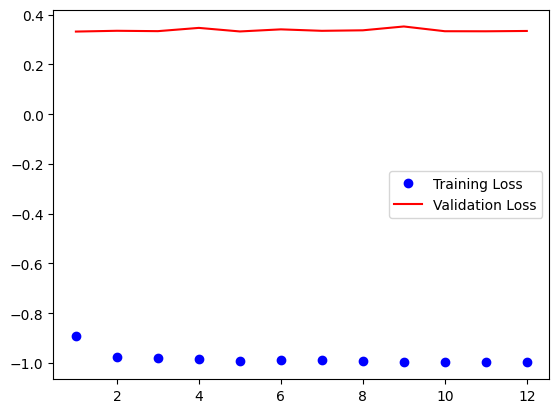

In [25]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(train_losses)+1), train_losses, 'bo', label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, 'r', label='Validation Loss')
plt.legend()

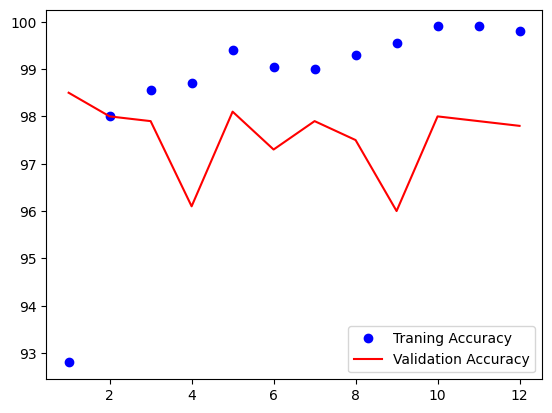

In [26]:
plt.plot(range(1, len(train_accuracy)+1), train_accuracy, 'bo', label="Traning Accuracy")
plt.plot(range(1, len(val_accuracy)+1), val_accuracy, 'r', label="Validation Accuracy")
plt.legend()

In [27]:
!ls

cats_and_dogs_filtered	    label_map.txt		     sample_data
cats_and_dogs_filtered.zip  PyTorch_Classification_Model.pt


In [29]:
import os
PATH = "/content/cats_and_dogs_filtered/validation"
validation_cats_dir = PATH + '/cats'
validation_dogs_dir = PATH + '/dogs'

list_of_test_cats_images  = os.listdir(validation_cats_dir)
list_of_test_dogs_images  = os.listdir(validation_dogs_dir)

for idx in range(len(list_of_test_cats_images )):
    list_of_test_cats_images[idx] = validation_cats_dir + '/' + list_of_test_cats_images[idx]

for idx in range(len(list_of_test_dogs_images )):
    list_of_test_dogs_images[idx] = validation_dogs_dir + '/' + list_of_test_dogs_images[idx]

list_of_test_images = list_of_test_cats_images + list_of_test_dogs_images

In [30]:
print(list_of_test_cats_images[10])
print(list_of_test_images[501])

/content/cats_and_dogs_filtered/validation/cats/cat.2263.jpg
/content/cats_and_dogs_filtered/validation/dogs/dog.2069.jpg


In [31]:
# 이미지 보여주는 함수, 이미지 추론 함수

from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt


def load_label_map(textFile):
    return np.loadtxt(textFile, str, delimiter='\t')

def cv_image_read(image_path):
    print(image_path)
    return cv2.imread(image_path)

def show_image(cv_image):
    rgb = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(rgb)
    plt.show()

def print_result(inference_result, class_map):
    class_text = class_map[np.argmax(inference_result)]
    print(inference_result)
    print(class_text)

def inference_image(opencv_image, transform_info, model, DEVICE):
    image = Image.fromarray(opencv_image)
    image_tensor = transform_info(image)
    image_tensor = image_tensor.unsqueeze(0)
    image_tensor = image_tensor.to(DEVICE)
    result = model(image_tensor)
    return result

/content/cats_and_dogs_filtered/validation/cats/cat.2263.jpg


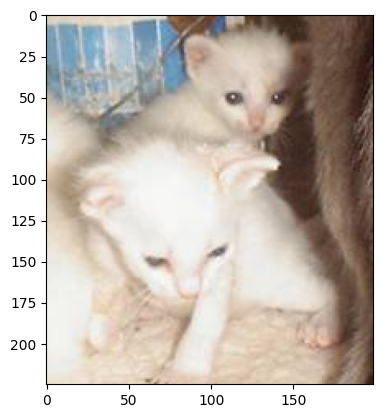

/content/cats_and_dogs_filtered/validation/dogs/dog.2069.jpg


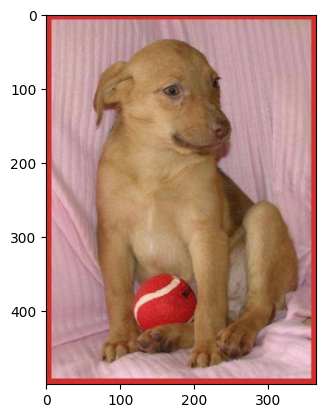

In [32]:
show_image(cv_image_read(list_of_test_images[10]))
show_image(cv_image_read(list_of_test_images[501]))

In [37]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

def testmain(image_path):
    USE_CUDA = torch.cuda.is_available()
    DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

    img_width, img_height = 224, 224
    transform_info = transforms.Compose([
                transforms.Resize(size=(img_width, img_height))
                , transforms.ToTensor()
                    ])
    class_map = load_label_map('label_map.txt')
    num_classes = len(class_map)

    model = Model(num_classes).to(DEVICE)
    model_str = "PyTorch_Classification_Model"
    model_str += ".pt"

    model.load_state_dict(torch.load(model_str))
    model.eval()

    opencv_image = cv_image_read(image_path)
    inference_result = inference_image(opencv_image, transform_info, model, DEVICE)
    inference_result = inference_result.cpu().detach().numpy()
    print_result(inference_result, class_map)
    show_image(opencv_image)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-37-e4c75a1d2796>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more detai

/content/cats_and_dogs_filtered/validation/cats/cat.2263.jpg
[[0.99924076 0.00199165]]
cats


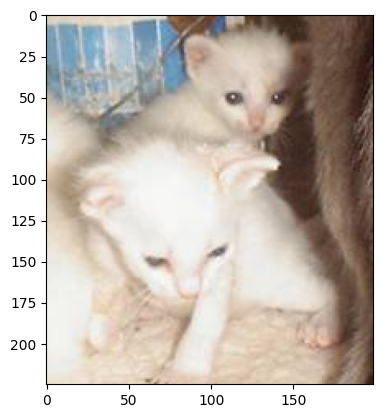

/content/cats_and_dogs_filtered/validation/dogs/dog.2069.jpg
[[0.02079662 0.97867554]]
dogs


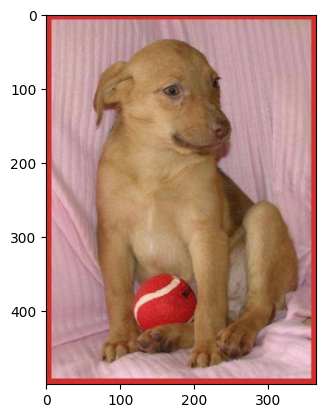

In [38]:
image_path = list_of_test_images[10]
testmain(image_path)

image_path = list_of_test_images[501]
testmain(image_path)